In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import pandas as pd

# Задание 1

![Решение первого](1.jpg)

# Задание 2

![Решение второго](2.jpg)

# Задание 3

У нас есть группа людей, и каждый из них тайно выбирает самое крутое число по его мнению, например, от 0 до 1000.Задача - найти число, за которое проголосовало больше всего людей.

Генерируем синтетические данные: каждый из n_people пользователей сообщает свое число, которое им больше всего нравится. Распределение этих чисел будем генерировать бета-распределением с параметрами (a, b)


In [2]:
def generate_votes(
    n_people: int,
    min_number: int = 1,
    max_number: int = 100,
    a: float = 2.0,
    b: float = 5.0,
    plot: bool = True,
    random_state: int = 42
) -> np.ndarray:
    """
    Генерирует тайные голоса людей за 'самое крутое число',
    используя бета-распределение, масштабированное на [min_number, max_number],
    и округляет до целых чисел.

    Параметры:
    ----------
    n_people : int
        Количество голосующих.
    min_number : int
        Минимальное возможное число (включительно).
    max_number : int
        Максимальное возможное число (включительно).
    a, b : float
        Параметры бета-распределения (a > 0, b > 0).
        - a < b -> больше голосов за маленькие числа
        - a > b -> больше голосов за большие числа
    plot : bool
        Если True — строит гистограмму распределения голосов.
    random_state : int
        Для воспроизводимости.

    Возвращает:
    -----------
    np.ndarray из int
        Массив чисел, за которые проголосовали люди.
    """
    rng = np.random.default_rng(random_state)
    beta_samples = rng.beta(a, b, size=n_people)
    continuous_numbers = min_number + (max_number - min_number) * beta_samples
    votes = np.round(continuous_numbers).astype(int)
    votes = np.clip(votes, min_number, max_number)

    if plot:
        plt.figure(figsize=(8, 5))
        plt.hist(votes, bins=min(50, max_number - min_number + 1), 
                density=False, alpha=0.7, color='royalblue', edgecolor='black')
        plt.title(f"Распределение голосов ({n_people} человек)\na={a}, b={b}")
        plt.xlabel("Число")
        plt.ylabel("Число голосов")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    return votes


def vote_count(number: int, votes: np.ndarray) -> int:
    """
    Считает, сколько людей проголосовало за данное число.

    Параметры:
    ----------
    number : int
        Число, за которое считаем голоса.
    votes : np.ndarray
        Массив голосов (каждый элемент — число, за которое проголосовал человек).
    
    Возвращает:
    ----------
    int
        Количество голосов за это число.
    """
    return (votes == number).sum()


def exponential_mechanism(candidates: np.ndarray, votes: np.ndarray, eps: float, sensitivity: float = 1, random_state=None) -> int:
    """
    Выбирает 'самое крутое число' с помощью экспоненциального механизма,
    гарантируя ε-дифференциальную приватность.

    Параметры:
    ----------
    candidates : np.ndarray
        Множество возможных чисел (кандидатов на 'амое крутое).
    votes : np.ndarray
        Массив тайных голосов людей.
    eps : float
        Уровень приватности.
    sensitivity : float
        Чувствительность.
    random_state : int, optional
        Для воспроизводимости.

    Возвращает:
    ----------
    int
        Число, выбранное как самое крутое с учётом приватности.
    """
    rng = np.random.default_rng(random_state)
    
    # Считаем, сколько голосов за каждое число
    counts = np.array([vote_count(num, votes) for num in candidates])
    
    # Численно стабильная экспонента
    max_count = np.max(counts)
    weights = np.exp(eps * (counts - max_count) / (2 * sensitivity))
    
    # Вероятности
    probs = weights / weights.sum()
    
    # Случайный выбор с учётом вероятностей
    chosen_index = rng.choice(len(candidates), p=probs)
    return candidates[chosen_index]


def noisy_max(candidates: np.ndarray, votes: np.ndarray, eps: float, sensitivity: float = 1, random_state=None) -> int:
    """
    Выбирает 'самое крутое число' с помощью зашумлённого максимума:
    к количеству голосов за каждое число добавляется экспоненциальный шум,
    затем выбирается число с максимальным зашумлённым счётом.

    Параметры:
    ----------
    candidates : np.ndarray
        Множество возможных чисел.
    votes : np.ndarray
        Массив тайных голосов.
    eps : float
        Уровень приватности.
    sensitivity : float
        Чувствительность.
    random_state : int, optional
        Для воспроизводимости.

    Возвращает:
    ----------
    int
        Число, выбранное как 'самое крутое' после добавления шума.
    """
    rng = np.random.default_rng(random_state)
    
    # Считаем голоса за каждое число
    counts = np.array([vote_count(num, votes) for num in candidates])
    
    # Добавляем экспоненциальный шум
    scale = 2 * sensitivity / eps
    noise = rng.exponential(scale=scale, size=len(candidates))
    noisy_scores = counts + noise
    
    # Выбираем число с максимальным зашумлённым счётом
    chosen_index = np.argmax(noisy_scores)
    return candidates[chosen_index]


def true_most_voted_number(candidates: np.ndarray, votes: np.ndarray) -> int:
    """
    Находит число, за которое проголосовало больше всего людей
    (истинный режим распределения голосов).

    Параметры:
    ----------
    candidates : np.ndarray
        Множество возможных чисел.
    votes : np.ndarray
        Массив голосов.

    Возвращает:
    ----------
    int
        Самое популярное число (без шума).
    """
    counts = np.array([vote_count(num, votes) for num in candidates])
    return candidates[np.argmax(counts)]

def run_experiment(candidates: np.ndarray, votes: np.ndarray, eps: float, sensitivity: float = 1.0, n_trials: int = 1000):
    """
    Сравнивает два DP-механизма на задаче выбора самого популярного числа.
    Возвращает статистику по выбранным числам.

    Параметры:
    ----------
    candidates : np.ndarray
        Множество возможных чисел.
    votes : np.ndarray
        Массив тайных голосов.
    eps : float
        Уровень приватности.
    sensitivity : float
        Чувствительность функции подсчёта голосов.
    n_trials : int
        Количество повторений эксперимента.

    Возвращает:
    ----------
    dict с метриками, основанными на выбранных числах:
        - 'eps': уровень приватности
        - 'true_most_voted': истинное самое популярное число
        - 'exp_mean_number': среднее выбранное число (экспоненциальный механизм)
        - 'noisy_mean_number': среднее выбранное число (зашумлённый максимум)
        - 'exp_std_number': стандартное отклонение выбранных чисел
        - 'noisy_std_number': стандартное отклонение выбранных чисел
        - 'exp_opt_freq': доля точных попаданий в истинное число
        - 'noisy_opt_freq': доля точных попаданий в истинное число
        - доверительные интервалы для средних значений
    """
    true_best = true_most_voted_number(candidates, votes)
    
    # Списки выбранных чисел (а не количества голосов!)
    exp_numbers = []
    noisy_numbers = []
    exp_correct = 0
    noisy_correct = 0

    for i in range(n_trials):
        # Экспоненциальный механизм
        num_exp = exponential_mechanism(candidates, votes, eps, sensitivity, random_state=i)
        exp_numbers.append(num_exp)
        if num_exp == true_best:
            exp_correct += 1

        # Зашумлённый максимум
        num_noisy = noisy_max(candidates, votes, eps, sensitivity, random_state=i + n_trials)
        noisy_numbers.append(num_noisy)
        if num_noisy == true_best:
            noisy_correct += 1

    # Статистика по выбранным числам
    exp_numbers = np.array(exp_numbers)
    noisy_numbers = np.array(noisy_numbers)
    
    exp_mean = np.mean(exp_numbers)
    exp_std = np.std(exp_numbers)
    noisy_mean = np.mean(noisy_numbers)
    noisy_std = np.std(noisy_numbers)

    # Доверительные интервалы для средних значений
    z = 1.96  # 95% доверительный интервал
    exp_ci = z * exp_std / np.sqrt(n_trials)
    noisy_ci = z * noisy_std / np.sqrt(n_trials)

    return {
        'eps': eps,
        'true_most_voted': true_best,
        'exp_mean_number': exp_mean,
        'exp_std_number': exp_std,
        'exp_ci_number': exp_ci,
        'noisy_mean_number': noisy_mean,
        'noisy_std_number': noisy_std,
        'noisy_ci_number': noisy_ci,
        'exp_opt_freq': exp_correct / n_trials,
        'noisy_opt_freq': noisy_correct / n_trials,
    }

Функция полезности определена как:

$q(y,D)$=число пользователей, у которых $x_i = y$

Рассмотрим две соседние базы данных $D$ и $D'$, отличающиеся ровно одним элементом (один пользователь добавлен или удалён).

Для любого фиксированного $y$:

1) Если старый пользователь голосовал за y , а новый - нет, то $q(y,D)$ уменьшится на 1;
2) Если старый не голосовал за y , а новый - да, то $q(y,D)$ увеличится на 1;
3) Если оба голосовали (или не голосовали) за $y$ , то значение не изменится.

Следовательно, максимальное возможное изменение полезности:

$∣q(y,D)−q(y,D')∣<=1$ для всех $y,D,D'$.
 
Поэтому чувствительность:

$\Delta = 1$

Тесты (a=3, b=5, поэтому смещение влево есть)

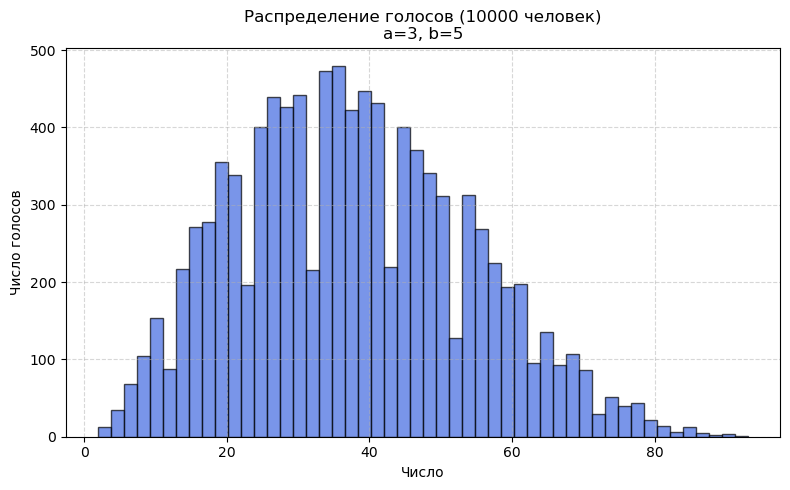

Запуск для eps = 0.1...
Запуск для eps = 0.3...
Запуск для eps = 0.5...
Запуск для eps = 0.7...
Запуск для eps = 1.0...

Результаты эксперимента:
   eps  true_most_voted  exp_mean_number  exp_std_number  exp_opt_freq  \
0  0.1               36           35.035           5.579         0.307   
1  0.3               36           35.872           1.092         0.924   
2  0.5               36           35.992           0.126         0.996   
3  0.7               36           36.000           0.000         1.000   
4  1.0               36           36.000           0.000         1.000   

   noisy_mean_number  noisy_std_number  noisy_opt_freq  
0             34.945             5.042           0.343  
1             35.947             0.636           0.970  
2             35.996             0.089           0.998  
3             36.000             0.000           1.000  
4             36.000             0.000           1.000  


In [3]:
D = generate_votes(n_people=10000, min_number=0, max_number=100, a=3, b=5, random_state=42, plot=true_most_voted_number)
candidates = np.array([i for i in range(D.min(), D.max() + 1)])
sensitivity = 1

epsilons = [0.1, 0.3, 0.5, 0.7, 1.0]
n_trials = 1000

results = []
for eps in epsilons:
    print(f"Запуск для eps = {eps}...")
    res = run_experiment(candidates, D, eps, sensitivity, n_trials)
    results.append(res)

df = pd.DataFrame(results)

# Вывод результатов
print("\nРезультаты эксперимента:")
print(df[['eps', 'true_most_voted', 'exp_mean_number', 'exp_std_number', 'exp_opt_freq', 'noisy_mean_number', 'noisy_std_number', 'noisy_opt_freq']].round(3))

Визуализация

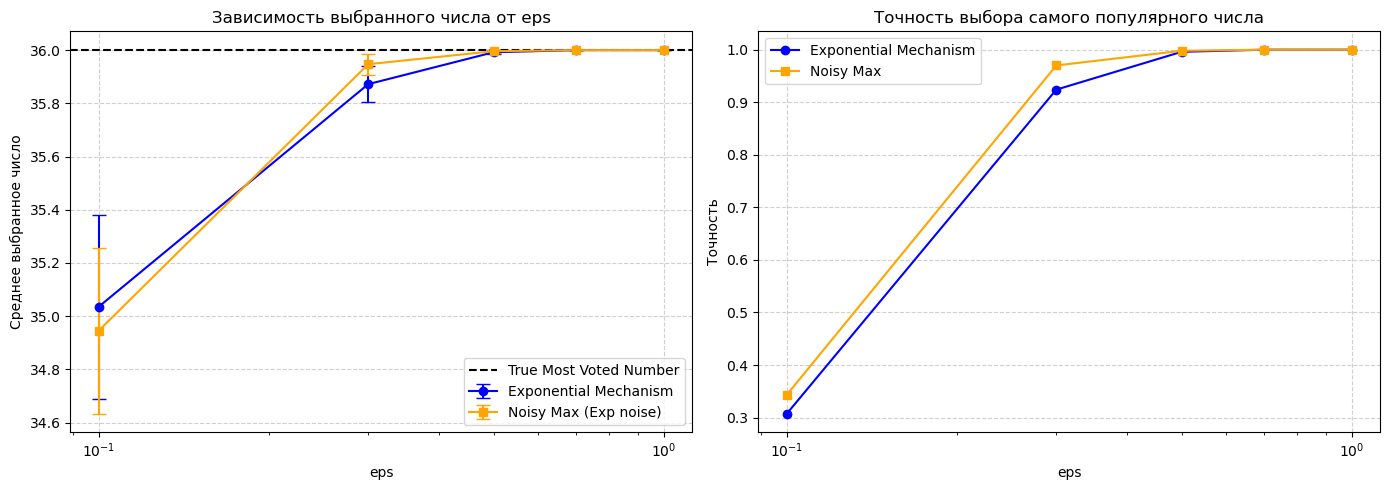

In [4]:
plt.figure(figsize=(14, 5))

# График 1: Среднее выбранное число
plt.subplot(1, 2, 1)
plt.errorbar(df['eps'], df['exp_mean_number'], yerr=df['exp_ci_number'], 
             label='Exponential Mechanism', marker='o', capsize=5, color='blue')
plt.errorbar(df['eps'], df['noisy_mean_number'], yerr=df['noisy_ci_number'], 
             label='Noisy Max (Exp noise)', marker='s', capsize=5, color='orange')
plt.axhline(df['true_most_voted'][0], color='k', linestyle='--', label='True Most Voted Number')
plt.xscale('log')
plt.xlabel('eps')
plt.ylabel('Среднее выбранное число')
plt.title('Зависимость выбранного числа от eps')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# График 2: Частота точного выбора истинного числа
plt.subplot(1, 2, 2)
plt.plot(df['eps'], df['exp_opt_freq'], label='Exponential Mechanism', marker='o', color='blue')
plt.plot(df['eps'], df['noisy_opt_freq'], label='Noisy Max', marker='s', color='orange')
plt.xscale('log')
plt.xlabel('eps')
plt.ylabel('Точность')
plt.title('Точность выбора самого популярного числа')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Для объективного сравнения экспоненциального механизма и зашумлённого максимума были выбраны два ключевых критерия:

1) Среднее выбранное число - показывает, насколько близко результат к истинному самому популярному числу (смещение/точность);
2) Частота точного выбора - доля экспериментов, где механизм верно идентифицировал истинное самое популярное число (точность попадания).
3) Отклонение

Повторные эксперименты обязательны, потому что оба механизма рандомизированы - один запуск не отражает среднее поведение. Доверительные интервалы выбран 95%. 


1) При большой приватности ($\epsilon = 0.1$):

- Оба механизма работают почти одинаково — частота точного выбора ~30%.

2) При умеренной приватности ($\epsilon = 0.3–0.5$):

- Зашумленный максимум начинает превосходить экспоненциальный механизм по частоте точного выбора.

3) При малой приватности ($\epsilon >= 0.7$):

- Оба механизма работают отлично, но зашумлённый максимум стабильно лучше.

- Оба достигают точного результата 

# Задание 4

### 1. Чувствительность функции

Рассмотрим функцию среднего:
$$
f(X) = \frac{1}{n} \sum_{i=1}^n x_i, \quad x_i \in \{0,1\}^d
$$

Чувствительность определяется как:
$$
\Delta_p = \sup_{X \sim X'} \|f(X) - f(X')\|_p, 
$$
где $X \sim X'$ — соседние базы данных (отличаются одним элементом).

Для двух соседних баз, отличающихся векторами $x_k$ и $x_k'$, имеем:
$$
f(X) - f(X') = \frac{1}{n}(x_k - x_k')
$$

При максимальной разнице ($x_k = \mathbf{1}, x_k' = \mathbf{0}$):

- **L1-чувствительность**:
  $$
  \Delta_1 = \left\| \frac{1}{n}(x_k - x_k') \right\|_1 = \frac{d}{n}
  $$

- **L2-чувствительность**:
  $$
  \Delta_2 = \left\| \frac{1}{n}(x_k - x_k') \right\|_2 = \frac{\sqrt{d}}{n}
  $$

### 2. Параметры шумов для DP-гарантий

- **Лапласовский шум** (обеспечивает $\varepsilon$-DP):  
  Каждая координата шума независимо распределена как:
  $$
  \xi_j \sim \text{Laplace}\left(\frac{\Delta_1}{\varepsilon}\right) = \text{Laplace}\left(\frac{d}{n\varepsilon}\right)
  $$

- **Гауссовский шум** (обеспечивает $(\varepsilon, \delta)$-DP, $\delta = \frac{1}{n}$):  
  Каждая координата шума независимо распределена как:
  $$  
  \xi_j \sim \mathcal{N}\left(0, \frac{{2 d}}{n^2 \varepsilon^2} log(n) \right),
  $$

### 3. Сравнение по дисперсии

В качестве основного критерия сравнения используем дисперсию (или MSE), поскольку оба механизма несмещённые (ну у иих нулевые мат ожидания):  
$$
\mathbb{E}[A(X)] = f(X) \quad \Rightarrow \quad \text{MSE} = \mathbb{E}[\|A(X) - f(X)\|_2^2] = \mathbb{E}[\|\xi\|_2^2] = \sum_{j=1}^d \text{Var}(\xi_j)
$$

- Лапласовский шум:  
  Каждая координата $\xi_j \sim \text{Laplace}\left(\dfrac{d}{n\varepsilon}\right)$.  
  Дисперсия одномерного распределения Лапласа с параметром масштаба $b$ равна $2b^2$, поэтому:
  $$
  \text{Var}(\xi_j^{\text{Lap}}) = 2 \left( \frac{d}{n\varepsilon} \right)^2
  $$
  Общая MSE:
  $$
  \text{MSE}_{\text{Lap}} = \frac{2d^3}{n^2\varepsilon^2}
  $$

- Гауссовский шум:  
  Каждая координата $\xi_j \sim \mathcal{N}\left(0, \sigma^2\right)$, где
  $$
  \sigma^2 = \frac{2 d \log(1 / \delta)}{n^2 \varepsilon^2}, \quad \delta = \frac{1}{n}
  $$
  Дисперсия нормального распределения равна $\sigma^2$:
  $$
  \text{Var}(\xi_j^{\text{Gauss}}) = \frac{2 d \log(n)}{n^2 \varepsilon^2}
  $$
  Общая MSE:
  $$
  \text{MSE}_{\text{Gauss}} = \frac{2 d^2 \log(n)}{n^2 \varepsilon^2}
  $$

- В случае Лапласс используется L1-чувствительность $\Delta_1 = d/n$.  
  Поскольку шум добавляется независимо в каждую из $d$ координат, а масштаб шума линейно растёт с $d$, общая ошибка растёт как $d^3$.

- Гаусс использует L2-чувствительность $\Delta_2 = \sqrt{d}/n$.  
  Масштаб шума растёт как $\sqrt{d}$, поэтому дисперсия одной координаты $d$, а общая ошибка $d^2$.

**Зависимость от параметров**:

- От $d$:  
  - Лаплас: $\text{MSE}$ ведет себя как $d^3$  
  - Гаусс: $\text{MSE}$ ведет себя как $d^2 \ln n$  
  При больших $d$ Гаусс лучше.

- От $n$:  
  Оба: $1/n^2$, но у Гаусса есть дополнительный $\ln n$ множитель, то есть незначительное ухудшение с ростом $n$.

- От $\varepsilon$:  
  Оба: $1/\varepsilon^2$, то есть одинаковая зависимость.

**Лаплас эффективен в низких размерностях, а Гаусс - в высоких**.

In [5]:
def generate_binary_dataset(n: int, d: int, random_state=None) -> np.ndarray:
    """Генерирует X = {x_i}, где x_i из {0,1}^d"""
    rng = np.random.default_rng(random_state)
    return rng.integers(0, 2, size=(n, d))

def true_mean(X: np.ndarray) -> np.ndarray:
    """Вычисляет f(X) = (1/n) sum x_i"""
    return X.mean(axis=0)

def laplace_mechanism(X: np.ndarray, eps: float) -> np.ndarray:
    """Добавляет Лапласовский шум для eps-DP"""
    n, d = X.shape
    true_val = true_mean(X)
    
    # L1-чувствительность = d / n
    scale = d / (n * eps)
    
    # Независимый Лапласовский шум по каждой координате
    rng = np.random.default_rng()
    noise = rng.laplace(loc=0, scale=scale, size=d)
    
    return true_val + noise

def gaussian_mechanism(X: np.ndarray, eps: float, delta: float = None) -> np.ndarray:
    """Добавляет Гауссовский шум для (eps, delta)-DP"""
    n, d = X.shape
    if delta is None:
        delta = 1.0 / n
    
    true_val = true_mean(X)
    
    # L2-чувствительность = sqrt(d) / n
    sigma = (np.sqrt(d) / (n * eps)) * np.sqrt(2 * np.log(1 / delta))
    
    rng = np.random.default_rng()
    noise = rng.normal(loc=0, scale=sigma, size=d)
    
    return true_val + noise

def run_noise_experiment(n: int, d: int, eps: float, n_trials: int = 500, random_state_base=42):
    """Сравнивает два шума по средней L2-ошибке"""
    errors_laplace = []
    errors_gaussian = []
    
    for i in range(n_trials):
        X = generate_binary_dataset(n, d, random_state=random_state_base + i)
        true_val = true_mean(X)
        
        # Лаплас
        laplace_est = laplace_mechanism(X, eps)
        err_lap = np.linalg.norm(laplace_est - true_val) ** 2
        errors_laplace.append(err_lap)
        
        # Гаусс
        gaussian_est = gaussian_mechanism(X, eps, delta=1.0/n)
        err_gauss = np.linalg.norm(gaussian_est - true_val) ** 2
        errors_gaussian.append(err_gauss)
    
    return {
        'n': n,
        'd': d,
        'eps': eps,
        'laplace_mean_error': np.mean(errors_laplace),
        'laplace_std_error': np.std(errors_laplace),
        'gaussian_mean_error': np.mean(errors_gaussian),
        'gaussian_std_error': np.std(errors_gaussian),
        'n_trials': n_trials
    }

d=1, n=100
d=1, n=500
d=1, n=1000
d=1, n=2000
d=1, n=5000
d=1, n=10000


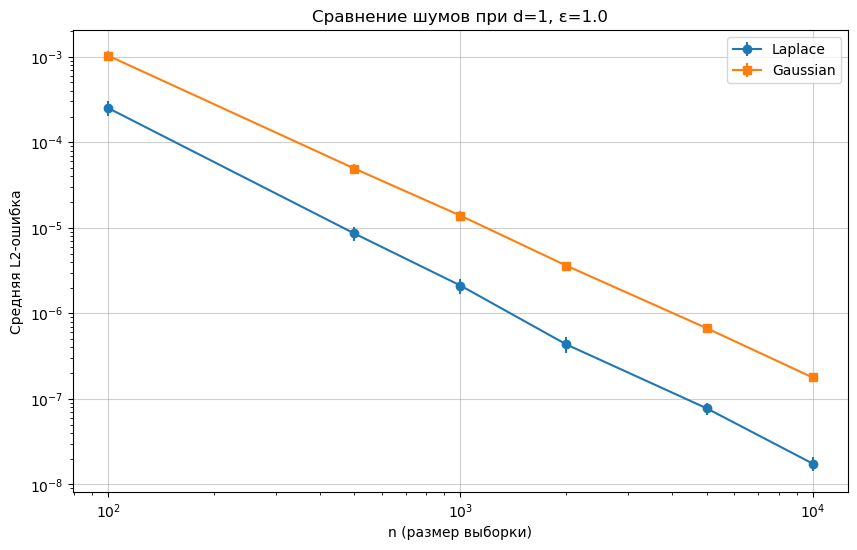

In [6]:
# Параметры
d = 1
eps = 1.0
n_values = [100, 500, 1000, 2000, 5000, 10000]
results_d1 = []

for n in n_values:
    print(f"d=1, n={n}")
    res = run_noise_experiment(n, d, eps, n_trials=500)
    results_d1.append(res)

df_d1 = pd.DataFrame(results_d1)

plt.figure(figsize=(10, 6))
plt.errorbar(df_d1['n'], df_d1['laplace_mean_error'], 
             yerr=1.96*df_d1['laplace_std_error']/np.sqrt(df_d1['n_trials']),
             label='Laplace', marker='o')
plt.errorbar(df_d1['n'], df_d1['gaussian_mean_error'], 
             yerr=1.96*df_d1['gaussian_std_error']/np.sqrt(df_d1['n_trials']),
             label='Gaussian', marker='s')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n (размер выборки)')
plt.ylabel('Средняя L2-ошибка')
plt.title('Сравнение шумов при d=1, ε=1.0')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

d=100, n=1000
d=100, n=2000
d=100, n=5000
d=100, n=10000
d=100, n=20000


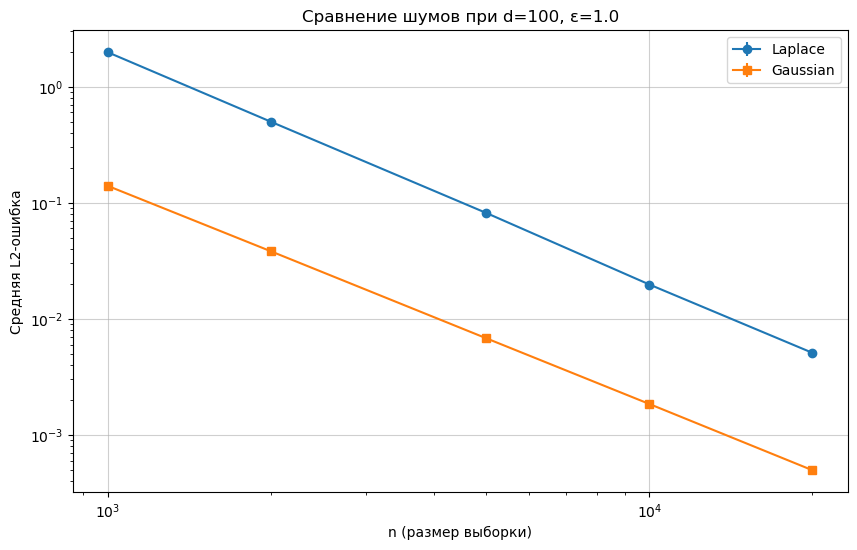

In [7]:
# Параметры
d = 100
eps = 1.0
n_values = [1000, 2000, 5000, 10000, 20000]
results_d100 = []

for n in n_values:
    print(f"d=100, n={n}")
    res = run_noise_experiment(n, d, eps, n_trials=300)
    results_d100.append(res)

df_d100 = pd.DataFrame(results_d100)

plt.figure(figsize=(10, 6))
plt.errorbar(df_d100['n'], df_d100['laplace_mean_error'], 
             yerr=1.96*df_d100['laplace_std_error']/np.sqrt(df_d100['n_trials']),
             label='Laplace', marker='o')
plt.errorbar(df_d100['n'], df_d100['gaussian_mean_error'], 
             yerr=1.96*df_d100['gaussian_std_error']/np.sqrt(df_d100['n_trials']),
             label='Gaussian', marker='s')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n (размер выборки)')
plt.ylabel('Средняя L2-ошибка')
plt.title('Сравнение шумов при d=100, ε=1.0')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

d=1, eps=0.1
d=1, eps=0.2
d=1, eps=0.5
d=1, eps=1.0


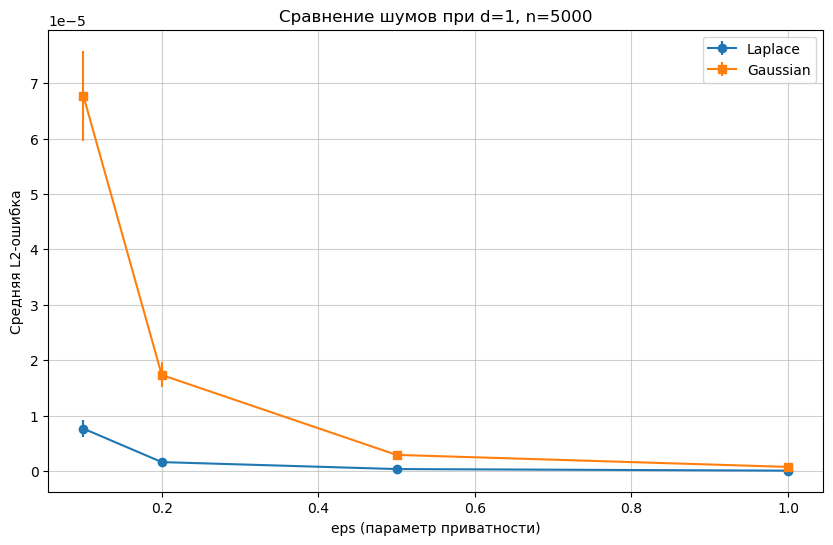

In [8]:
# Параметры
d = 1
eps_values = [0.1, 0.2, 0.5, 1.0]
n = 5000
results_d1 = []

for eps in eps_values:
    print(f"d=1, eps={eps}")
    res = run_noise_experiment(n, d, eps, n_trials=500)
    results_d1.append(res)

df_d1 = pd.DataFrame(results_d1)

plt.figure(figsize=(10, 6))
plt.errorbar(df_d1['eps'], df_d1['laplace_mean_error'], 
             yerr=1.96*df_d1['laplace_std_error']/np.sqrt(df_d1['n_trials']),
             label='Laplace', marker='o')
plt.errorbar(df_d1['eps'], df_d1['gaussian_mean_error'], 
             yerr=1.96*df_d1['gaussian_std_error']/np.sqrt(df_d1['n_trials']),
             label='Gaussian', marker='s')

plt.xlabel('eps (параметр приватности)')
plt.ylabel('Средняя L2-ошибка')
plt.title('Сравнение шумов при d=1, n=5000')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

d=100, eps=0.1
d=100, eps=0.2
d=100, eps=0.5
d=100, eps=1.0


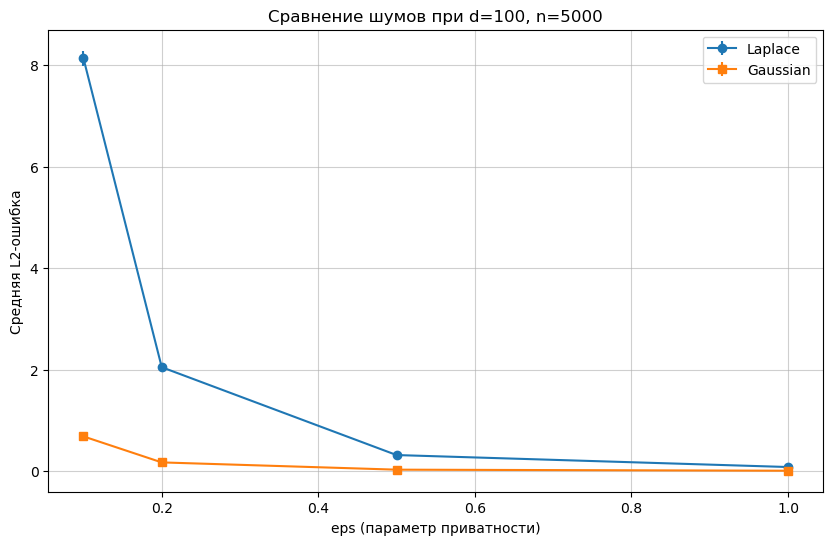

In [9]:
# Параметры
d = 100
eps_values = [0.1, 0.2, 0.5, 1.0]
n = 5000
results_d1 = []

for eps in eps_values:
    print(f"d=100, eps={eps}")
    res = run_noise_experiment(n, d, eps, n_trials=500)
    results_d1.append(res)

df_d1 = pd.DataFrame(results_d1)

plt.figure(figsize=(10, 6))
plt.errorbar(df_d1['eps'], df_d1['laplace_mean_error'], 
             yerr=1.96*df_d1['laplace_std_error']/np.sqrt(df_d1['n_trials']),
             label='Laplace', marker='o')
plt.errorbar(df_d1['eps'], df_d1['gaussian_mean_error'], 
             yerr=1.96*df_d1['gaussian_std_error']/np.sqrt(df_d1['n_trials']),
             label='Gaussian', marker='s')

plt.xlabel('eps (параметр приватности)')
plt.ylabel('Средняя L2-ошибка')
plt.title('Сравнение шумов при d=100, n=5000')
plt.legend()
plt.grid(True, alpha=0.6)
plt.show()

### 4. Результат по моделированию
Эксперименты необходимо повторять много раз (в моем случае 300–500 раз), потому что оба механизма рандомизированы

**Случай 1: $d = 1$**
- Оба механизма показывают сопоставимую точность
- Лапласовский шум демонстрирует чуть меньшую MSE, что согласуется с теорией ($d^3 = 1$ vs $d^2 \ln n = \ln n$)
- С ростом $n$ ошибка обоих методов убывает как $1/n^2$
- Графики MSE от $n$ показывает, что кривая Лапласа ниже

**Случай 2: $d = 100$**
- Гауссовский шум показывает меньшую MSE
- Лапласовский шум становится практически неприменимым из-за огромной ошибки при малых $n$
- Графики MSE от $n$ показывают, что кривая Лапласа находится значительно выше

**Дополнительные наблюдения**

- При фиксированном $d$ и $\varepsilon$ ошибка убывает с ростом $n$ для обоих методов
- При малых $\varepsilon$ абсолютная ошибка возрастает, но относительное преимущество Гаусса при больших $d$ сохраняется
- Доверительные интервалы узкие, что подтверждает стабильность результатов

**Вывод**

Практические эксперименты подтверждают теоретические предсказания:
- Для скалярных задач ($d = 1$) предпочтителен Лапласовский шум благодаря немного лучшей точности и строгой $\varepsilon$-DP гарантии
- Для высокоразмерных задач ($d \geq 100$) Гауссовский шум существенно превосходит Лаплас по точности